In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import keras
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

tickerList = ['AAPL', 'AMZN', 'ASML', 'AVGO', 'COST', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

# 데이터 로드

- 각 종목코드에 맞는 3년치 감정분석 데이터와 주가 데이터를 가져옵니다.

In [2]:
# 데이터 전처리 및 로드 함수
def data_load(ticker):
    # 시작 날짜와 종료 날짜 설정
    start_date = '2021-04-05'
    end_date = '2024-05-18'
    
    # MSFT의 경우 시작 날짜를 2021-04-06으로 설정
    if(ticker == 'MSFT'):
        start_date = '2021-04-06'

    # 주식 데이터 다운로드
    datas = yf.download(ticker, start=start_date, end=end_date)

    dic = {
        'ds' : datas.index,
        'y' : datas.Close,
    }

    finance_df = pd.DataFrame( dic )

    #인덱스 초기화(원본 까지 적용)
    finance_df.reset_index( inplace=True )

    del finance_df['Date']

    finance_df.head(5)
    finance_df.tail(5)

    csv_filename = f"./news_data/news_data_{ticker}.csv"
    result_df = pd.read_csv(csv_filename)
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values('date').reset_index(drop=True)
    date_range = pd.date_range(start=start_date, end=end_date)
    df_date_range = pd.DataFrame(date_range, columns=['date'])
    df_filtered = df_date_range[~df_date_range['date'].isin(finance_df['ds'])]
    common_dates = result_df[result_df['date'].isin(df_filtered['date'])]['date']
    result_filtered = result_df[~result_df['date'].isin(common_dates)]
    result_filtered.reset_index(inplace=True)
    result_filtered = result_filtered.drop(columns=['index'])
    # 데이터 로드
    return finance_df['y'].values, result_filtered['predict'].values

# 테스트 준비

- 테스트에 필요한 메소드 및 파라미터를 준비합니다.

In [3]:
# 상태 정의 함수
def get_state(data, t, n, sentiment_scores):
    if t == 0:
        return np.zeros((1, n))  # 초기 상태를 모두 0으로 설정
    
    d = t - n + 1
    if d >= 0:
        block = data[d:t + 1]
    else:
        # 이전 데이터가 없는 경우에는 0으로 채워진 배열을 생성합니다.
        prev_data = np.zeros((n - t - 1,))
        block = np.concatenate([prev_data, data[:t + 1]], axis=0)
    
    # Zero-padding if block length is less than n
    if len(block) < n:
        block = np.concatenate([np.zeros((n - len(block),)), block], axis=0)
    
    res = [block[i + 1] - block[i] for i in range(n - 1)]
    res.append(sentiment_scores[t])
    return np.array([res])

# Actor-Critic 모델 생성 함수 (동일한 모델 구조 사용)
def create_actor_critic_model(input_shape, num_actions):
    inputs = layers.Input(shape=input_shape)
    lstm_layer = layers.LSTM(64, return_sequences=True)(inputs)  # LSTM 레이어 추가
    lstm_layer = layers.LSTM(64)(lstm_layer)  # 추가 LSTM 레이어
    common = layers.Dense(128, activation="relu")(lstm_layer)
    action = layers.Dense(num_actions, activation="softmax")(common)
    critic = layers.Dense(1)(common)
    return keras.Model(inputs=inputs, outputs=[action, critic])

# 하이퍼파라미터 설정 (모델 생성시 사용된 동일한 하이퍼파라미터 사용)
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_max = 1.0
epsilon_interval = epsilon_max - epsilon_min
num_episodes = 500  # 에피소드 수
n = 10
input_shape = (n, 1)  # 상태 정의 함수의 n 값과 일치해야 함
num_actions = 3  # 예: 매수, 보유, 매도
learning_rate = 0.0001  # 학습률 조정
# discount_factor = 0.99  # 할인 계수 조정

# 모델 및 옵티마이저 생성
model = create_actor_critic_model(input_shape, num_actions)
optimizer = keras.optimizers.Adam(learning_rate)

# 체크포인트 디렉토리
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 체크포인트 설정
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{episode}-{step}")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

2024-06-13 17:02:33.368811: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-13 17:02:33.368832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-13 17:02:33.368839: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-13 17:02:33.368857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 17:02:33.368868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 모든 체크포인트 시각화

In [4]:
def visualise_total_checkpoint(ticker):
    # 주가 데이터와 감정 분석 값을 준비
    prices, sentiment_scores = data_load(ticker)

    # 평가 결과를 저장할 리스트 초기화
    checkpoint_episodes = list(range(10, num_episodes+10, 10))  # 10 에피소드 단위로 저장된 체크포인트
    eval_profits = []
    win_rates = []
    total_profits = []

    # 각 체크포인트에서 모델을 로드하고 성능 평가
    for episode in tqdm(checkpoint_episodes):
        # 체크포인트 파일 경로
        checkpoint_path = checkpoint_prefix.format(episode=episode, step=episode//10)
        
        # 체크포인트 로드
        checkpoint.restore(checkpoint_path).expect_partial()
        
        # 초기 상태
        state = get_state(prices, 0, 10, sentiment_scores)
        total_profit = 0
        total_buy = 0
        total_sell = 0
        holdings = 0
        num_buy = 0
        num_sell = 0
        num_trades = 0
        num_wins = 0

        # 시간 단계 루프
        for t in range(len(prices)):
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            action_probs, critic_value = model(state_tensor)
            action_probs = tf.squeeze(action_probs).numpy()

            action = np.argmax(action_probs)
            
            reward = 0
            if action == 0 and holdings < 50:  # 매수
                holdings += 1
                reward = -prices[t]
                total_buy += prices[t]
                num_buy += 1
                num_trades += 1
            elif action == 2 and holdings > 0:  # 매도
                holdings -= 1
                reward = prices[t] - (total_buy / num_buy) # 평균 매수 가격과 현재 가격의 차이
                total_sell += prices[t]
                num_sell += 1
                num_trades += 1
                if reward > 0:
                    num_wins += 1
            else:  # 보유
                # reward = (holdings * prices[t]) - total_buy
                reward = -holdings
            
            total_profit += reward

            next_state = get_state(prices, t, 10, sentiment_scores)
            state = next_state

        # 에피소드 종료 시 모든 주식 매도
        while holdings > 0:
            holdings -= 1
            reward = prices[-1] - (total_buy / num_buy) # 평균 매수 가격과 현재 가격의 차이
            total_profit += reward
            total_sell += prices[-1]
            num_sell += 1
            if reward > 0:
                num_wins += 1

        # 성능 평가 결과 저장
        win_rate = num_wins / num_trades if num_trades > 0 else 0
        eval_profits.append(total_profit)
        win_rates.append(win_rate)
        total_profits.append(total_sell - total_buy)

    # 그래프 그리기

    # 총 이익 시각화
    plt.figure(figsize=(14, 10))

    # 총 이익 그래프
    plt.subplot(3, 1, 1)
    plt.plot(checkpoint_episodes, eval_profits, label='Eval Profit')
    plt.xlabel('Episode')
    plt.ylabel('Eval Profit')
    plt.title('Eval Profit per Episode')
    plt.legend()

    # 승률 그래프
    plt.subplot(3, 1, 2)
    plt.plot(checkpoint_episodes, win_rates, label='Win Rate', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.title('Win Rate per Episode')
    plt.legend()

    # 총 이익 그래프
    plt.subplot(3, 1, 3)
    plt.plot(checkpoint_episodes, total_profits, label='Total Profit')
    plt.xlabel('Episode')
    plt.ylabel('Total Profit')
    plt.title('Total Profit per Episode')
    plt.legend()
    
    print(f"Ticker: {ticker}")

    plt.tight_layout()
    plt.show()

# 특정 체크포인트 에피소드 세부 시각화

In [5]:
def visualise_checkpoint(ticker, episode):
    # 주가 데이터와 감정 분석 값을 준비
    prices, sentiment_scores = data_load(ticker)

    # 평가 결과를 저장할 리스트 초기화
    actions = []
    profits = []
    eval_profits = []

    # 체크포인트 파일 경로
    checkpoint_path = checkpoint_prefix.format(episode=episode, step=episode//10)

    # 체크포인트 로드
    checkpoint.restore(checkpoint_path).expect_partial()

    # 초기 상태
    state = get_state(prices, 0, 10, sentiment_scores)
    eval_total_profit = 0
    total_buy = 0
    total_sell = 0
    holdings = 0
    num_buy = 0
    num_sell = 0
    num_trades = 0
    num_wins = 0
    buy_prices = [np.nan for _ in range(len(prices))]
    sell_prices = [np.nan for _ in range(len(prices))]

    # 시간 단계 루프
    for t in tqdm(range(len(prices))):
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        action_probs, critic_value = model(state_tensor)
        action_probs = tf.squeeze(action_probs).numpy()

        action = np.argmax(action_probs)
        actions.append(action)
        reward = 0
        if action == 0:  # 매수
            holdings += 1
            reward = -prices[t]
            total_buy += prices[t]
            num_buy += 1
            num_trades += 1
            buy_prices[t] = prices[t]
        elif action == 2 and holdings > 0:  # 매도
            holdings -= 1
            reward = prices[t] - (total_buy / num_buy) # 평균 매수 가격과 현재 가격의 차이
            total_sell += prices[t]
            num_sell += 1
            num_trades += 1
            if reward > 0:
                num_wins += 1
            sell_prices[t] = prices[t]
        else:  # 보유
            reward = -holdings
        
        eval_total_profit += reward
        eval_profits.append(reward)
        profits.append(total_sell - total_buy)

        next_state = get_state(prices, t, 10, sentiment_scores)
        state = next_state

    # 에피소드 종료 시 모든 주식 매도
    while holdings > 0:
        holdings -= 1
        reward = prices[-1] - (total_buy / num_buy) # 평균 매수 가격과 현재 가격의 차이
        eval_total_profit += reward
        eval_profits[-1] += reward
        total_sell += prices[-1]
        sell_prices[-1] = prices[-1]
        num_sell += 1
        if reward > 0:
            num_wins += 1

    profits[-1] = (total_sell - total_buy)

    # 성능 평가 결과 저장
    win_rate = num_wins / num_trades if num_trades > 0 else 0
    eval_profit = eval_total_profit
    total_profit = total_sell - total_buy

    # 그래프 그리기

    # 매수 및 매도 가격 그래프
    plt.figure(figsize=(14, 10))

    # 주가 그래프
    plt.subplot(5, 1, 1)
    plt.plot(prices, label='Price', color='black')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.xlim(0, len(prices))
    plt.title('Price per Time Step')
    plt.legend()

    # 행동 가격 그래프
    plt.subplot(5, 1, 2)
    plt.plot(buy_prices, label='Buy', color='blue')
    plt.plot(sell_prices, label='Sell', color='orange')
    plt.xlabel('Time Step')
    plt.ylabel('Action Price')
    plt.xlim(0, len(prices))
    plt.title('Action Price per Time Step')
    plt.legend()

    # 행동 그래프
    plt.subplot(5, 1, 3)
    plt.plot(actions, label='Action', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('Action')
    plt.xlim(0, len(prices))
    plt.title('Action per Time Step')
    plt.legend()

    # 수익 그래프
    plt.subplot(5, 1, 4)
    plt.plot(profits, label='Profit', color='red')
    plt.xlabel('Time Step')
    plt.ylabel('Profit')
    plt.xlim(0, len(prices))
    plt.title('Profit per Time Step')
    plt.legend()
    
    # 평가 수익 그래프
    plt.subplot(5, 1, 5)
    plt.plot(eval_profits, label='Eval Profit', color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Eval Profit')
    plt.xlim(0, len(prices))
    plt.title('Eval Profit per Time Step')
    plt.legend()

    print(f"Ticker: {ticker}")
    print(f"CheckPoint: {episode}")
    print(f"Final Profit: {profits[-1]}")
    print(f"Win Rate: {win_rate}")
    print(f"Eval Total Profit: {eval_profit}")
    print(f"Total Profit: {total_profit}")

    plt.tight_layout()
    plt.show()

# 각 주식별로 시각화 시작

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:34<00:00,  9.08s/it]


Ticker: AAPL


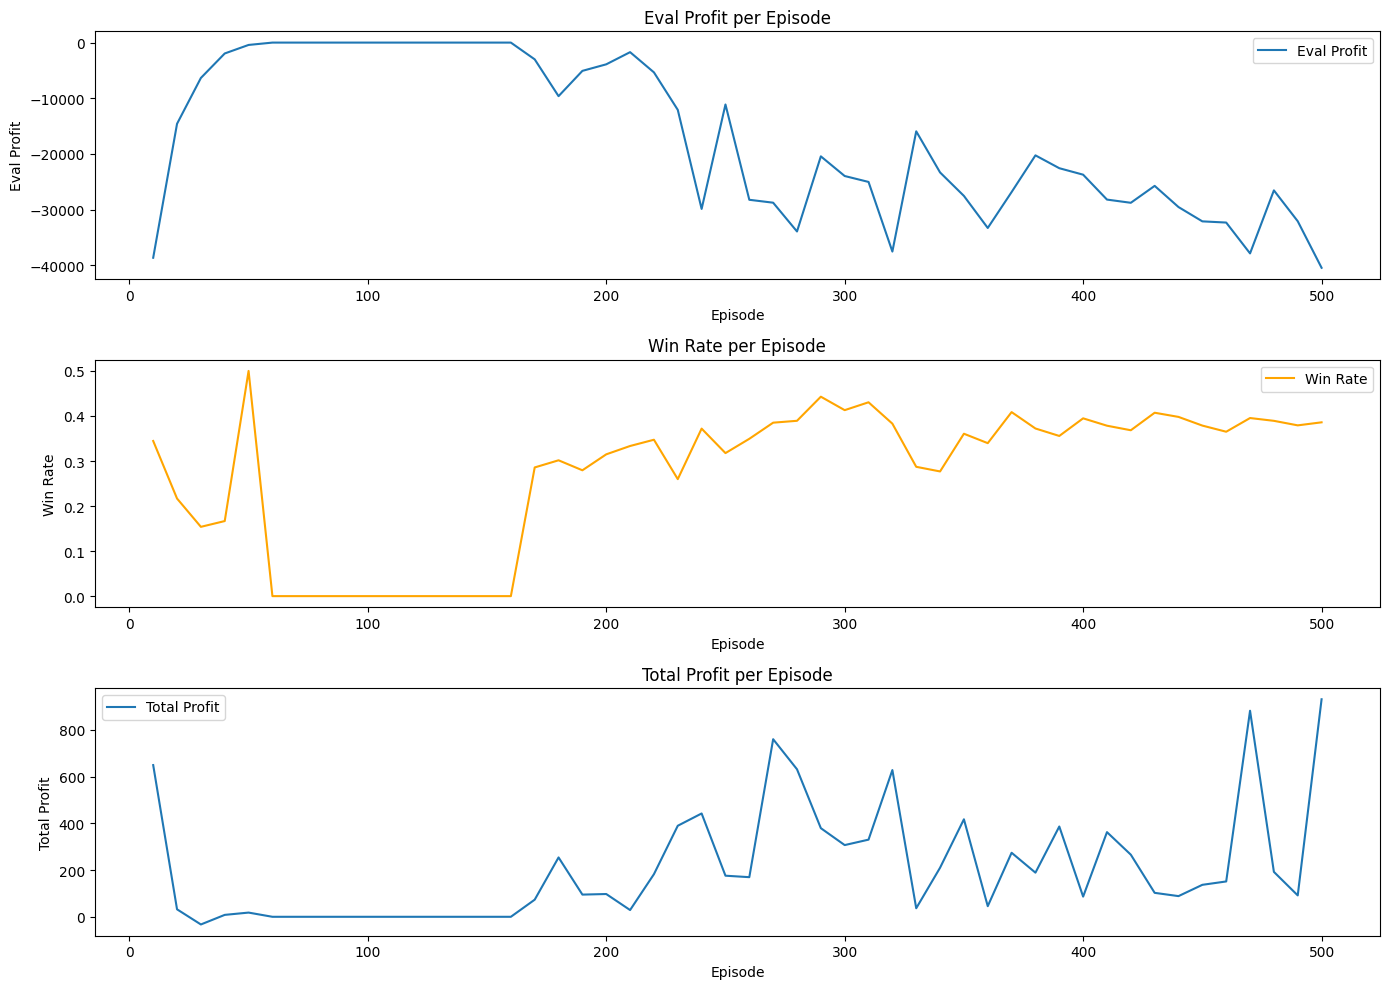

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:45<00:00,  9.31s/it]


Ticker: AMZN


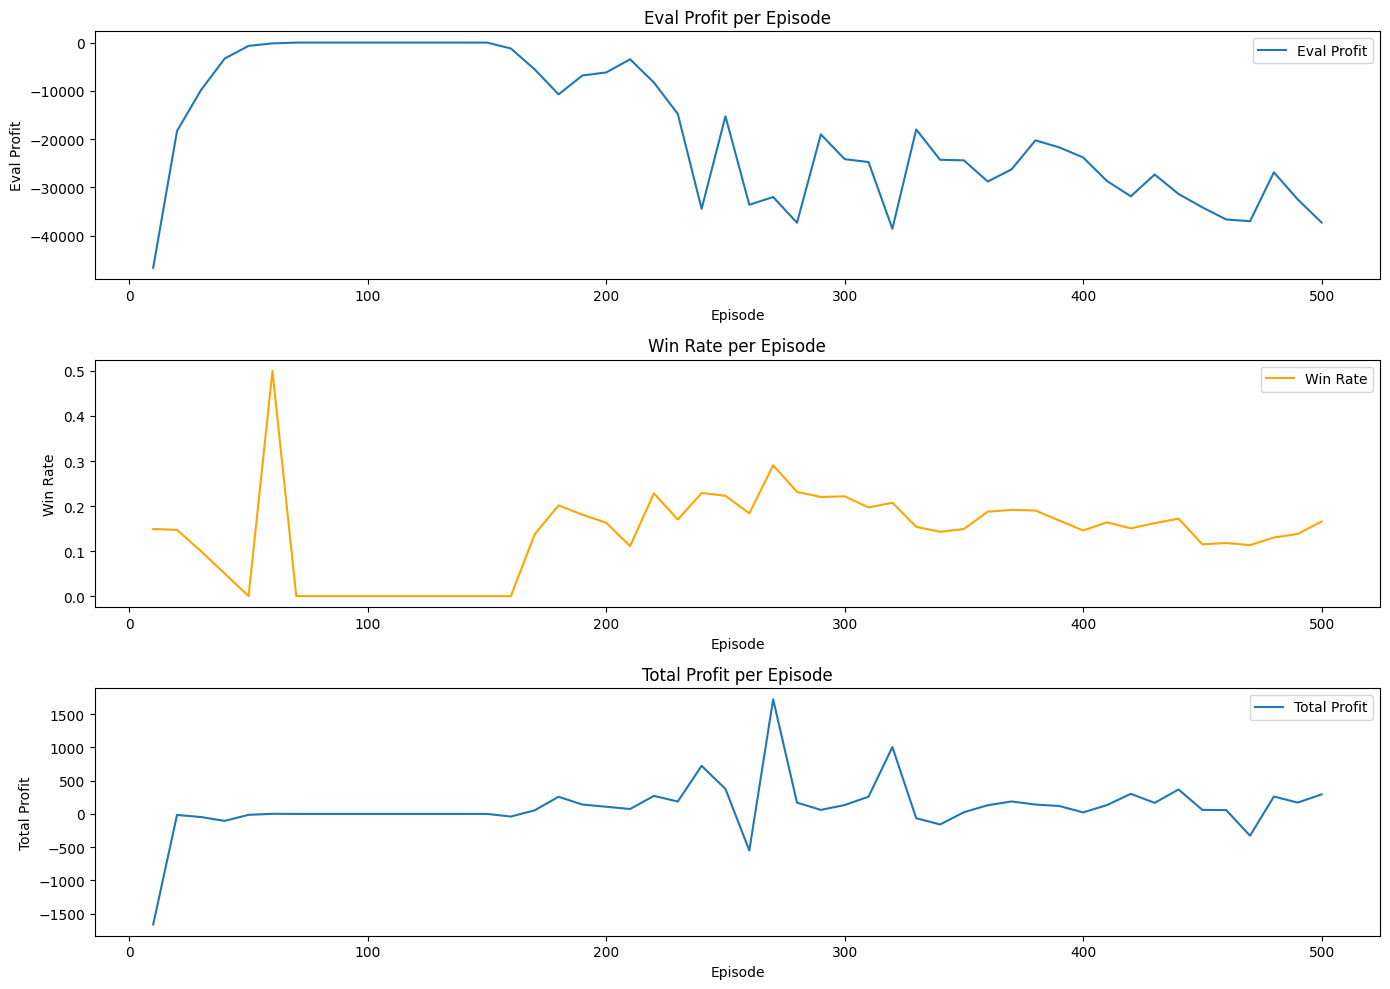

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:29<00:00,  9.00s/it]


Ticker: ASML


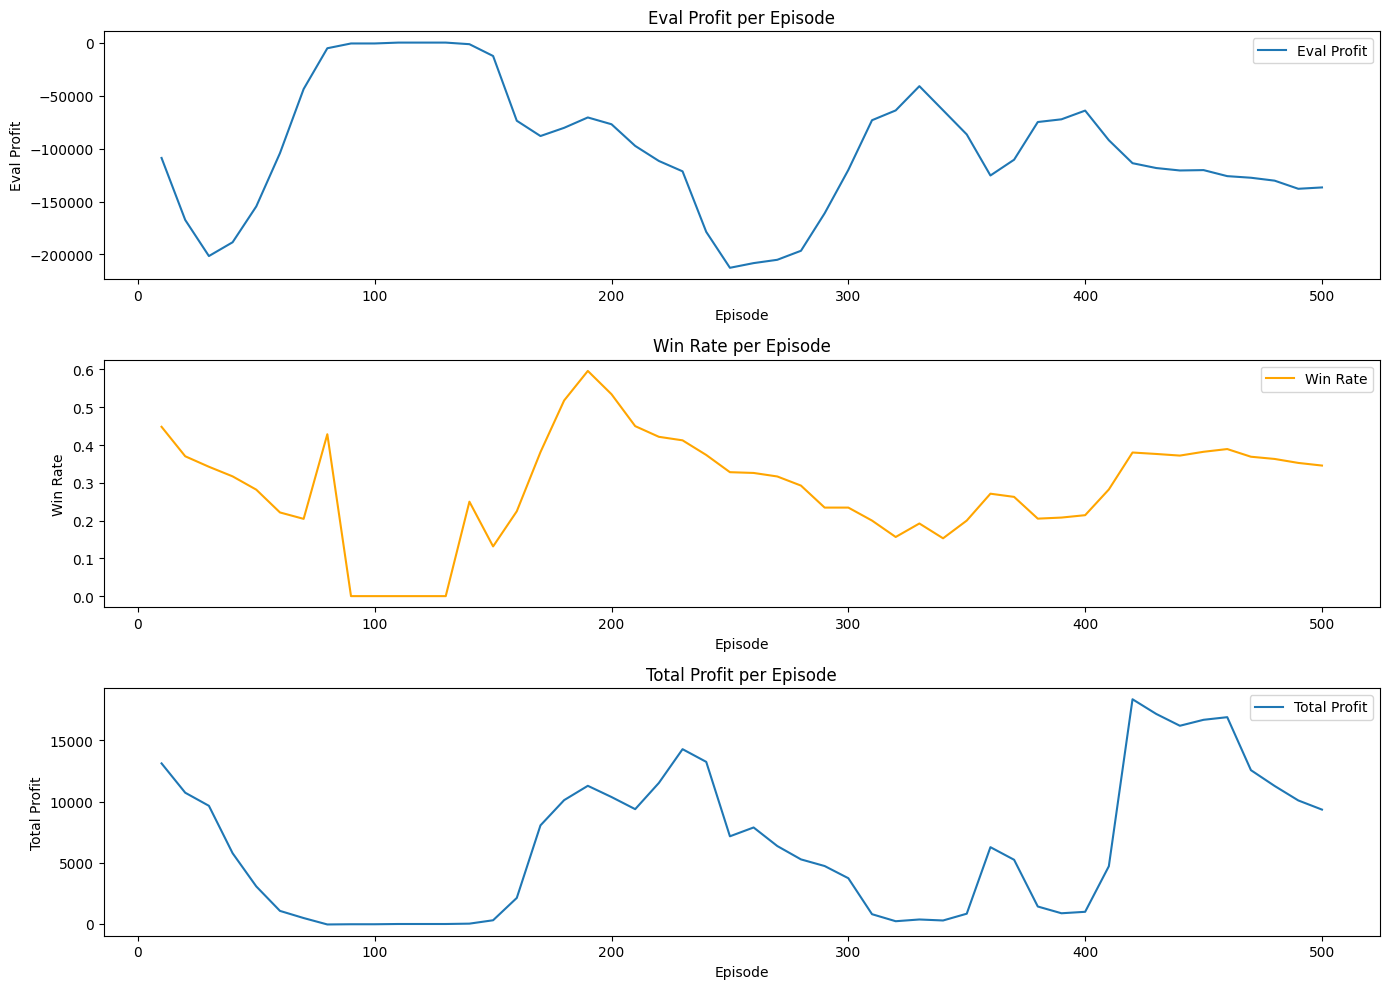

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:40<00:00,  9.21s/it]


Ticker: AVGO


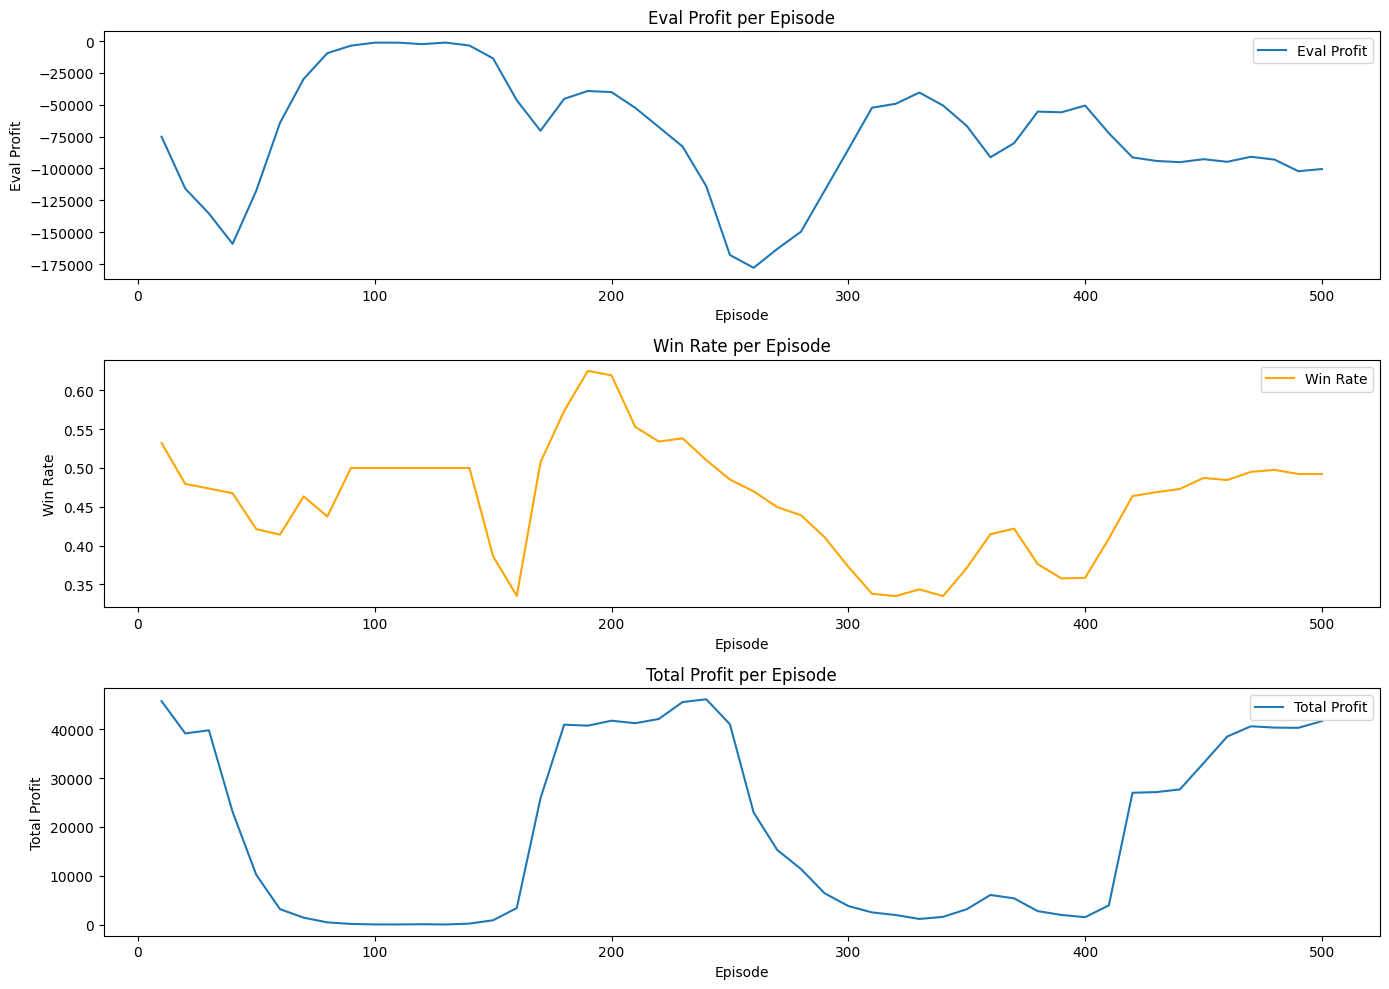

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:30<00:00,  9.01s/it]


Ticker: COST


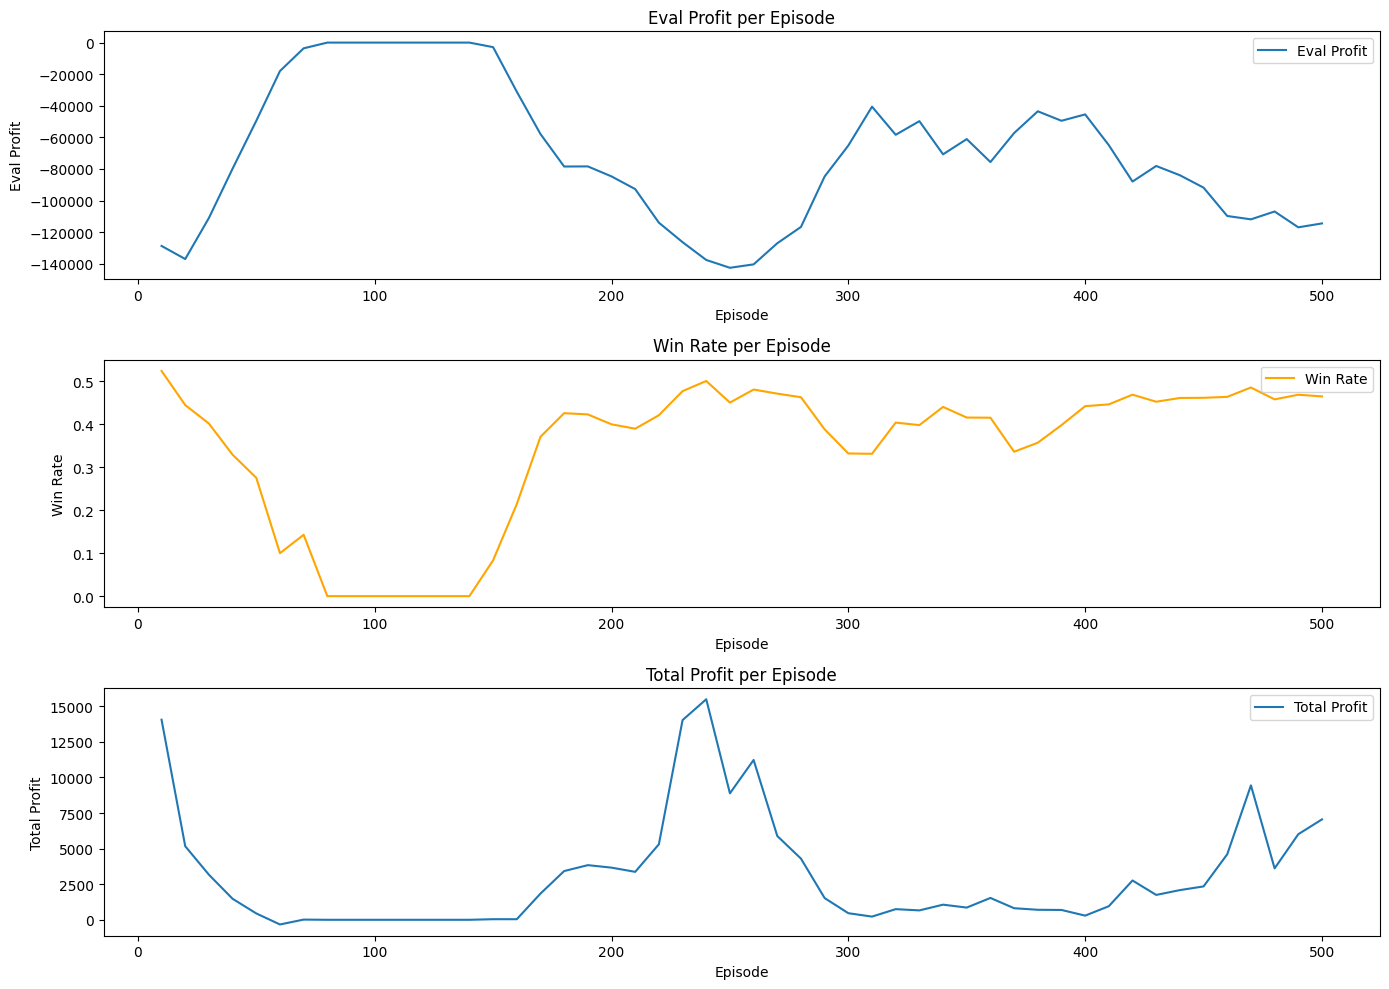

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:31<00:00,  9.03s/it]


Ticker: GOOG


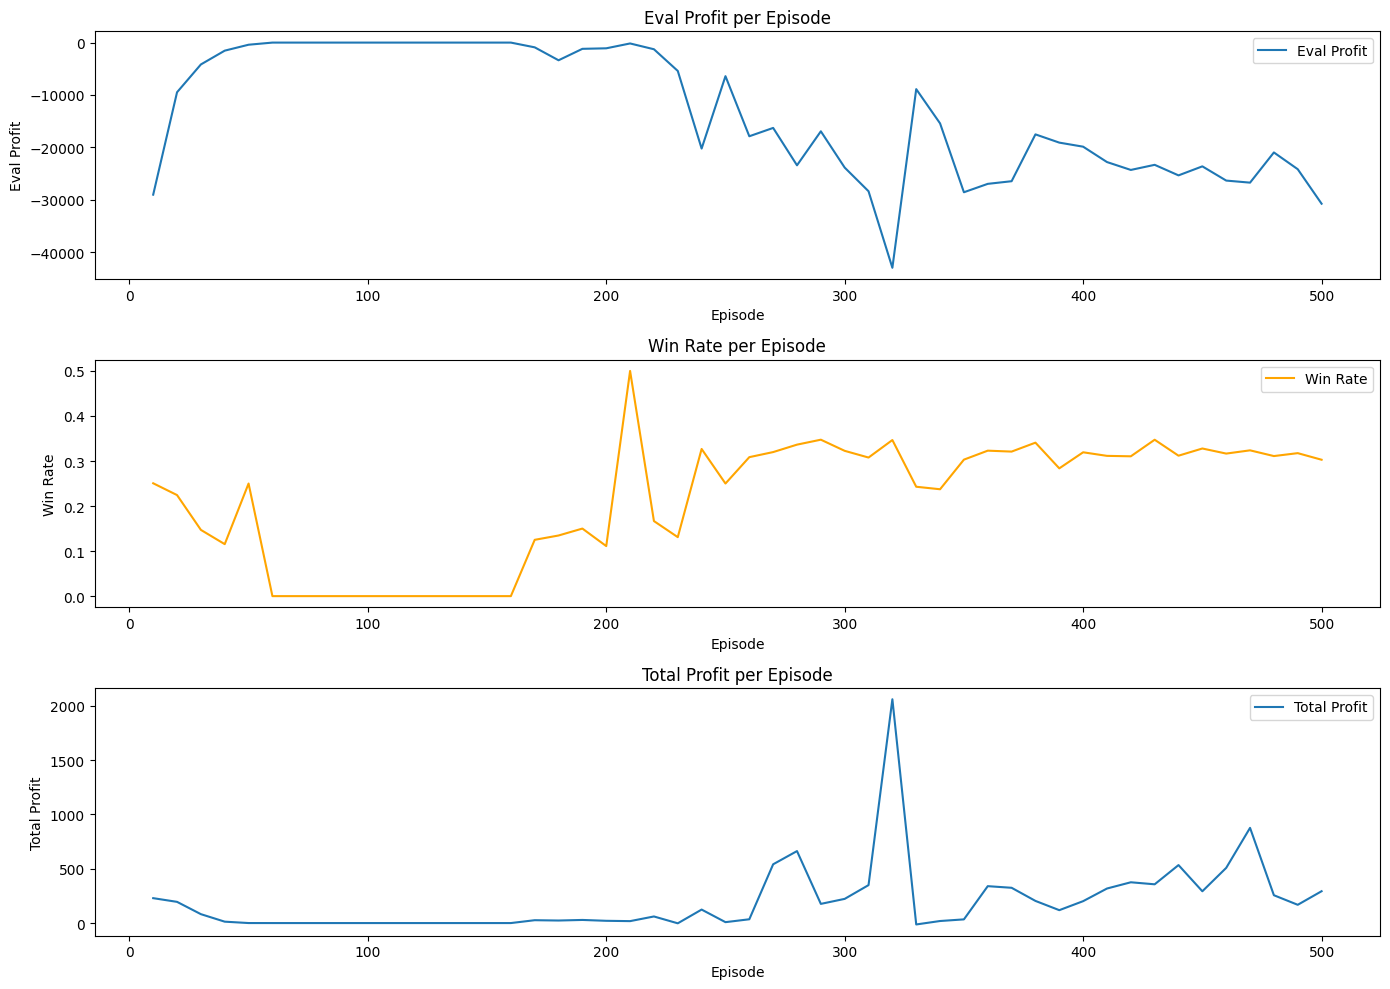

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:34<00:00,  9.08s/it]


Ticker: META


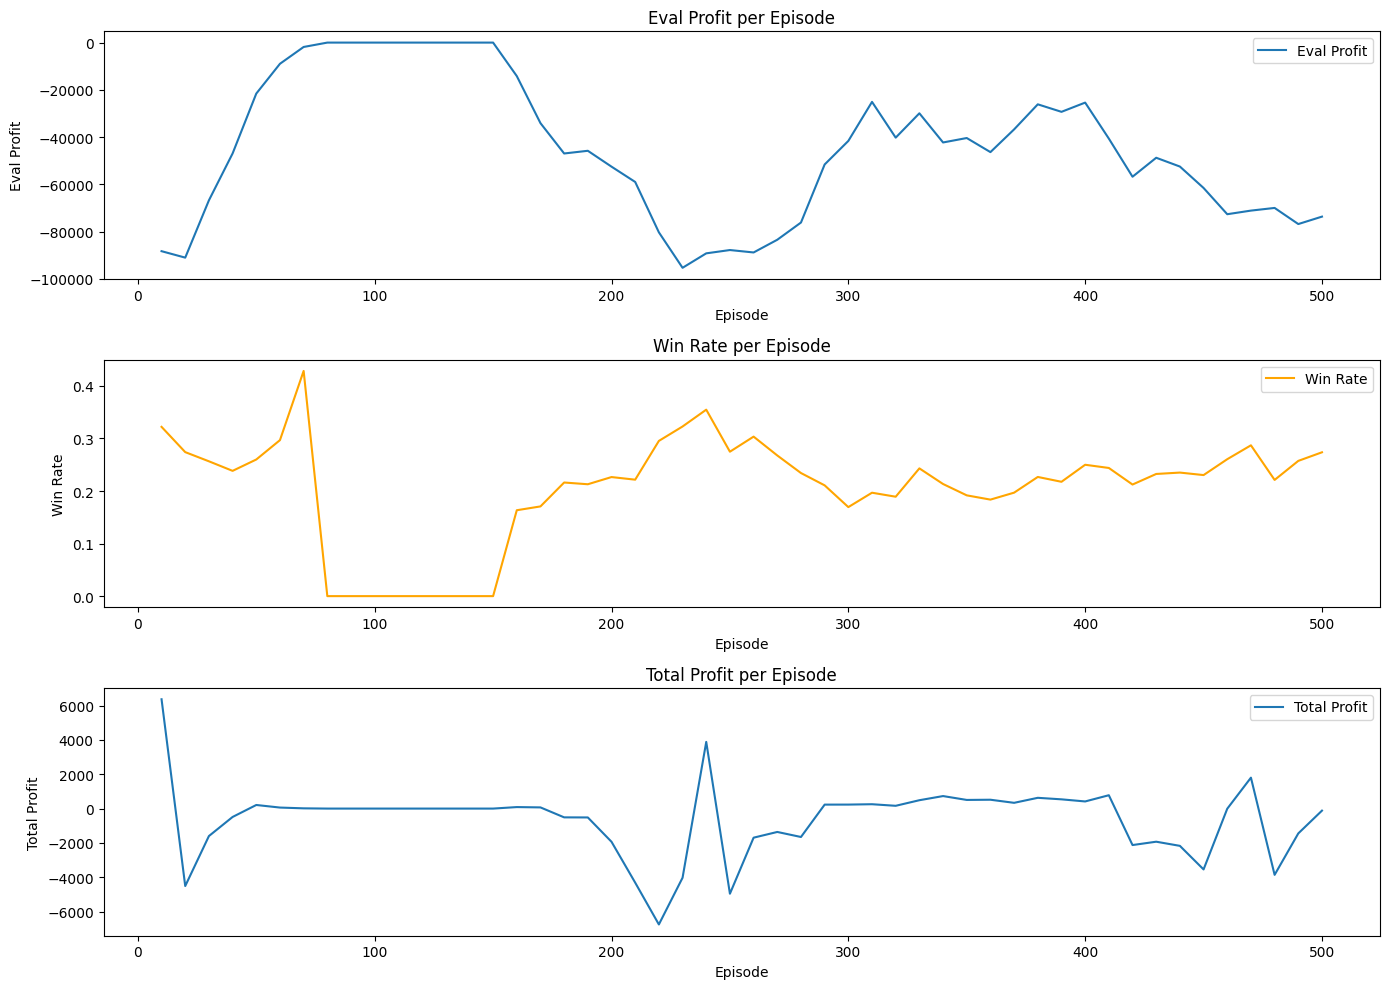

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:33<00:00,  9.06s/it]


Ticker: MSFT


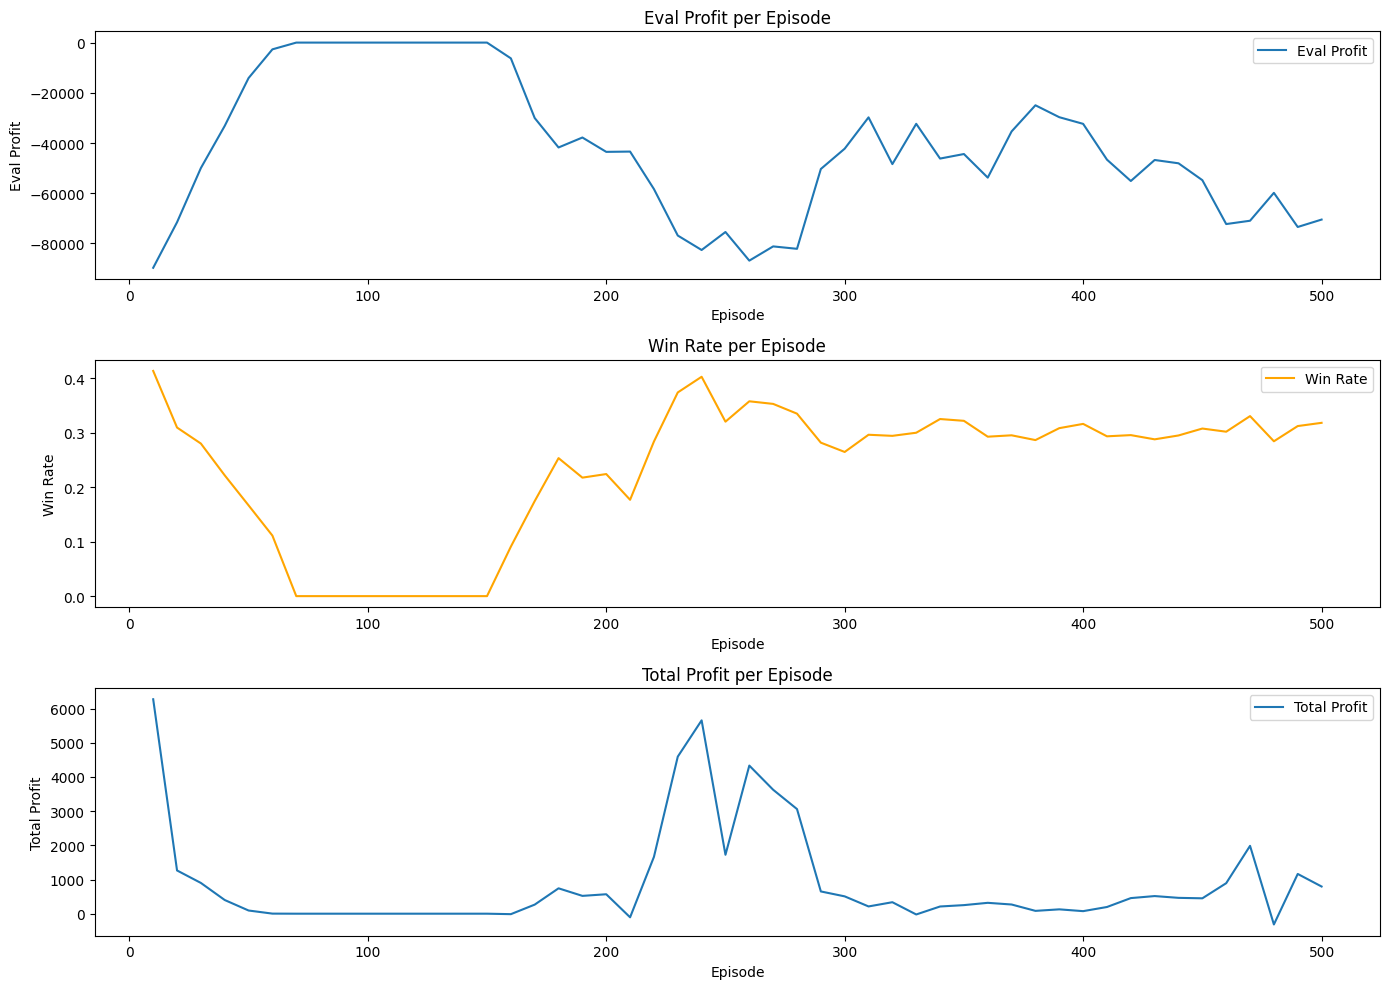

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:14<00:00,  8.70s/it]


Ticker: NVDA


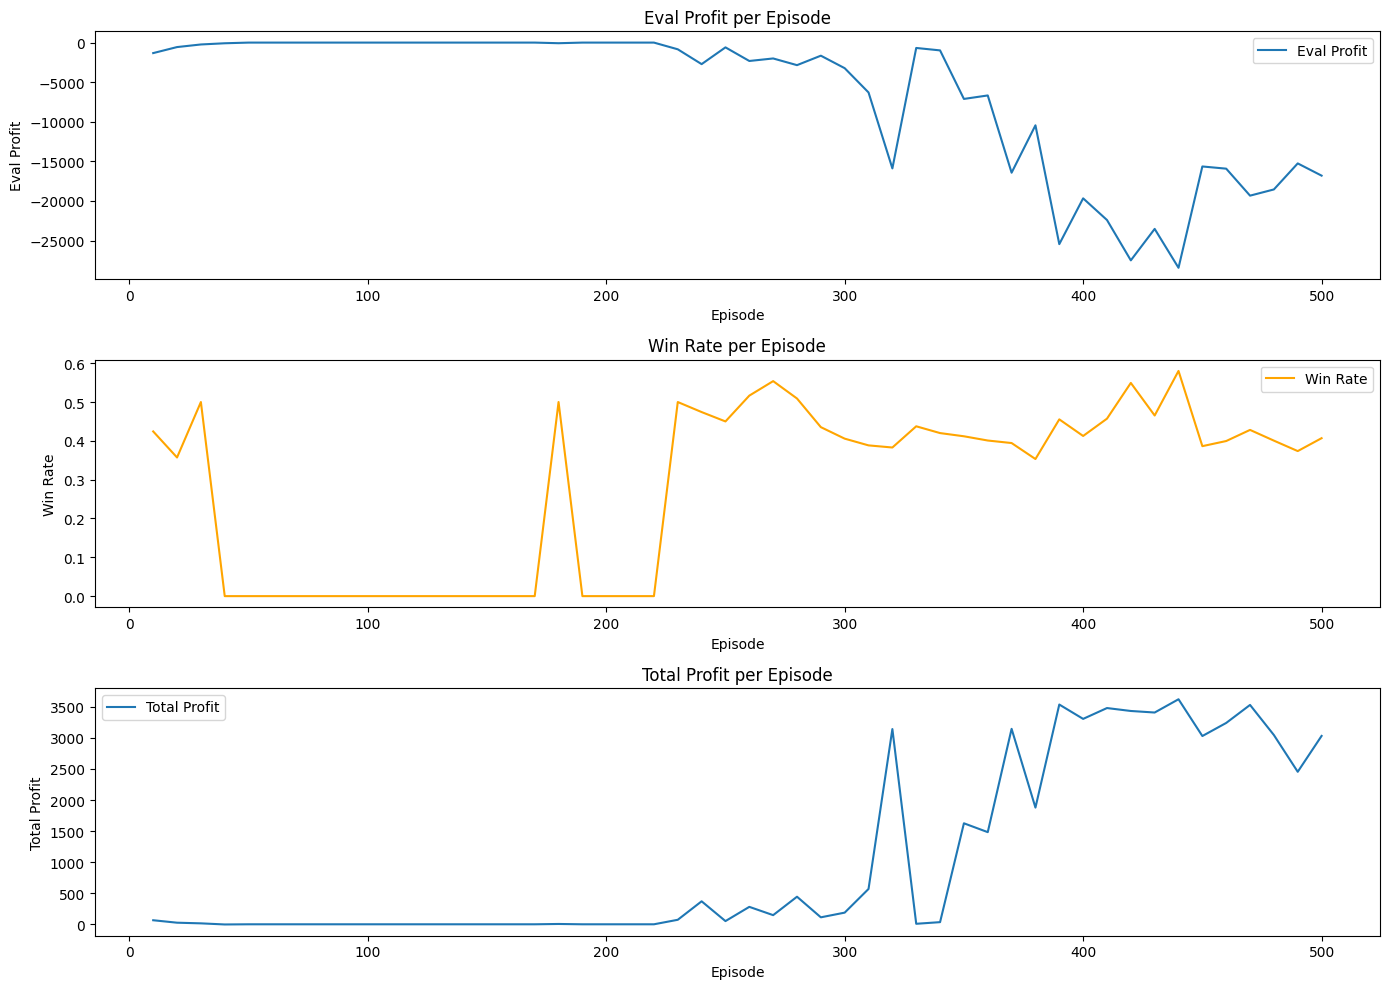

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 50/50 [07:25<00:00,  8.91s/it]


Ticker: TSLA


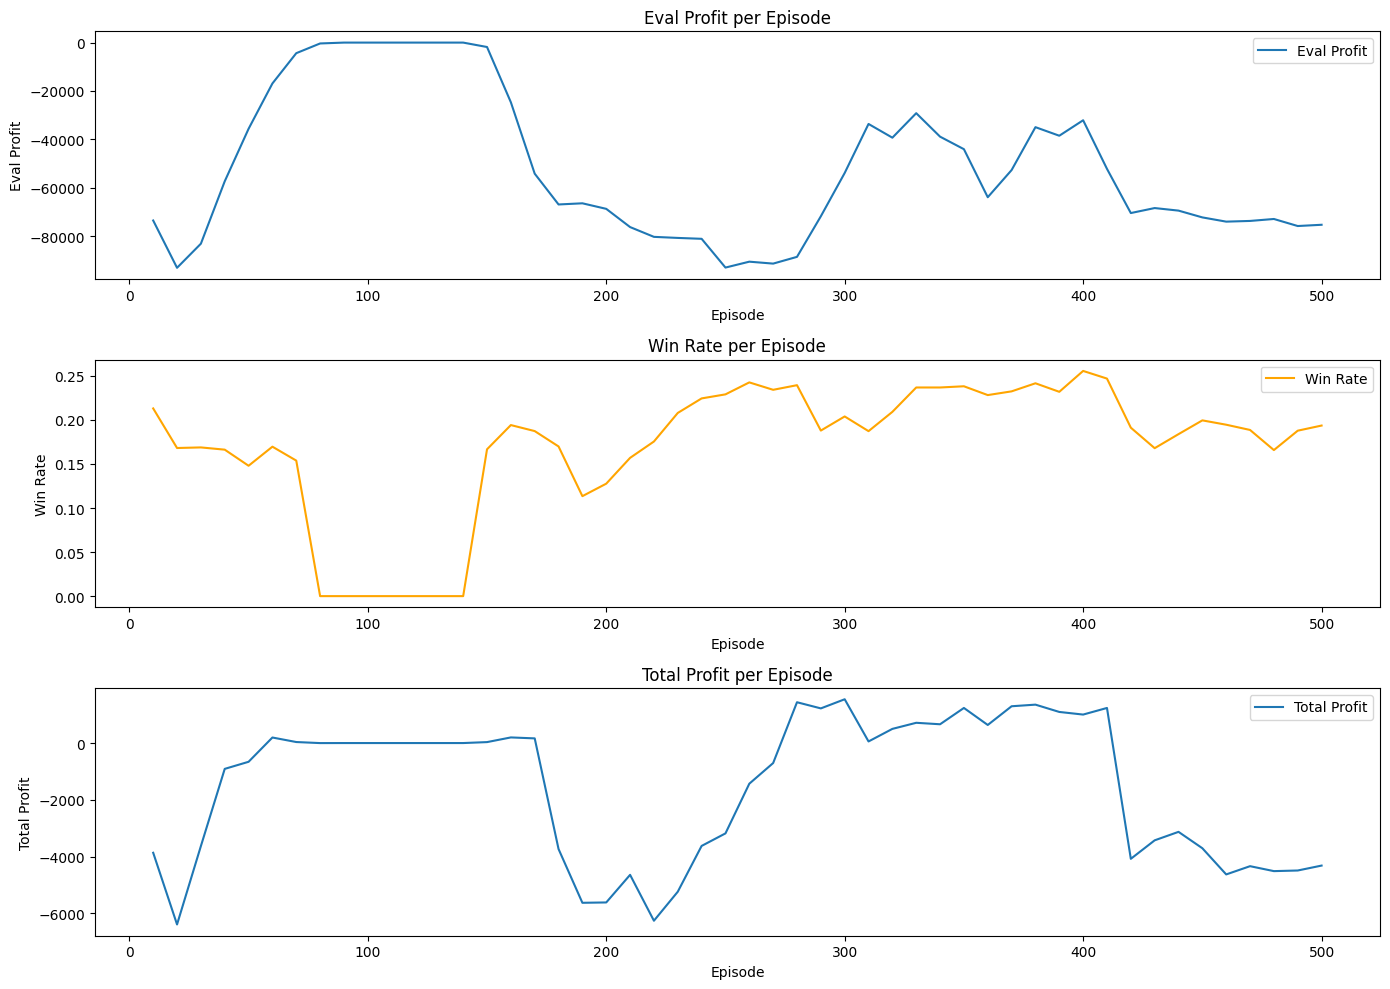

In [6]:
for ticker in tickerList:
    visualise_total_checkpoint(ticker)

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:10<00:00, 74.20it/s]


Ticker: AAPL
CheckPoint: 270
Final Profit: 760.0900802612305
Win Rate: 0.3851132686084142
Eval Total Profit: -28751.153250778243
Total Profit: 760.0900802612305


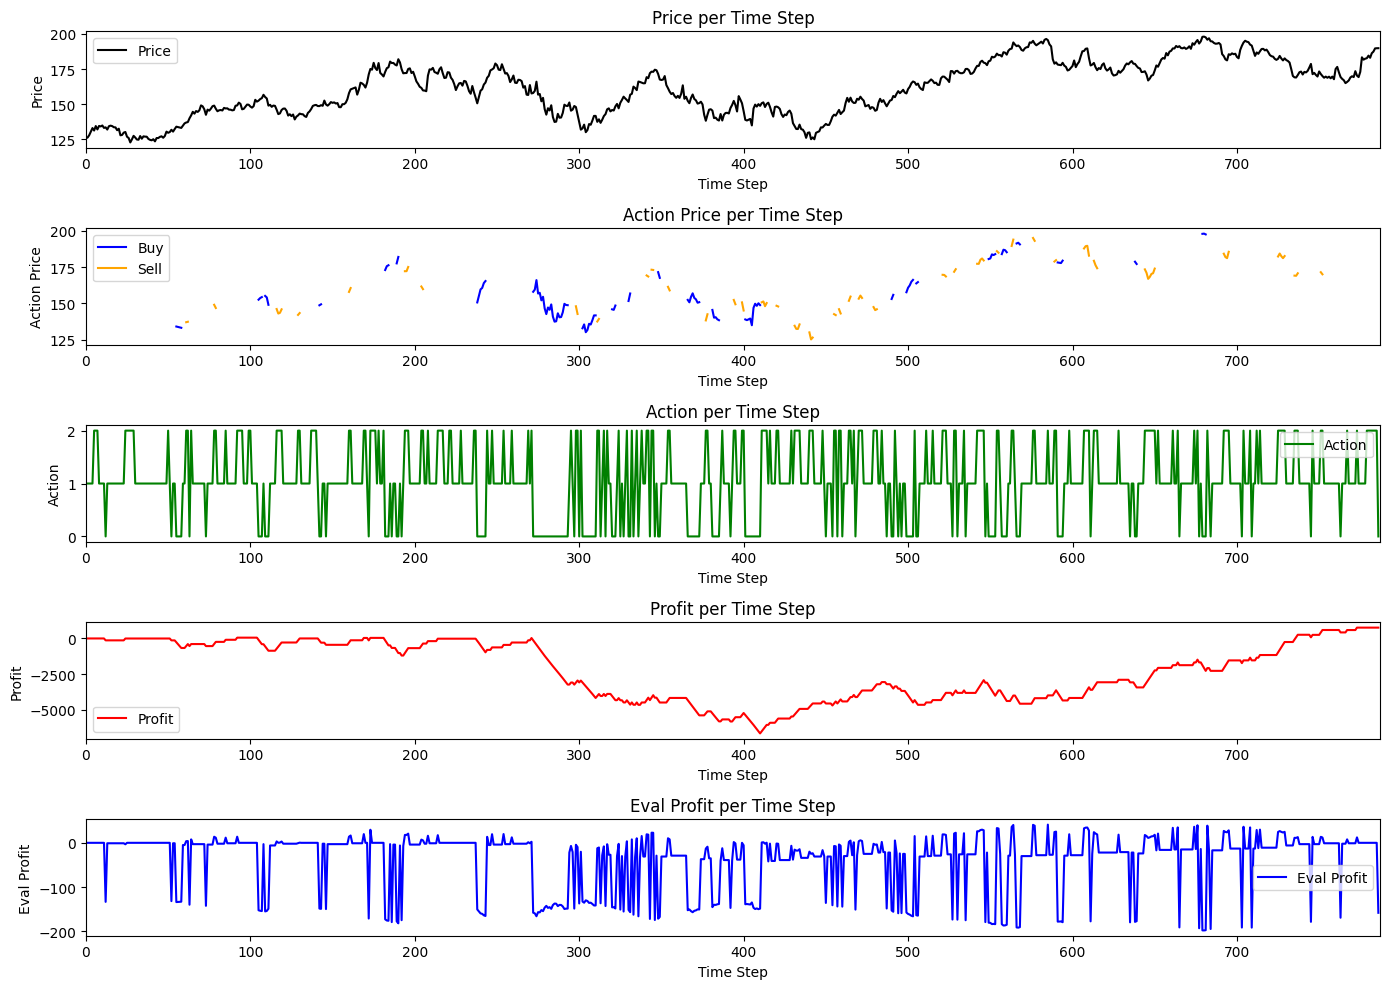

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 78.82it/s]


Ticker: AMZN
CheckPoint: 270
Final Profit: 1724.889389038086
Win Rate: 0.2905027932960894
Eval Total Profit: -31976.89486576058
Total Profit: 1724.889389038086


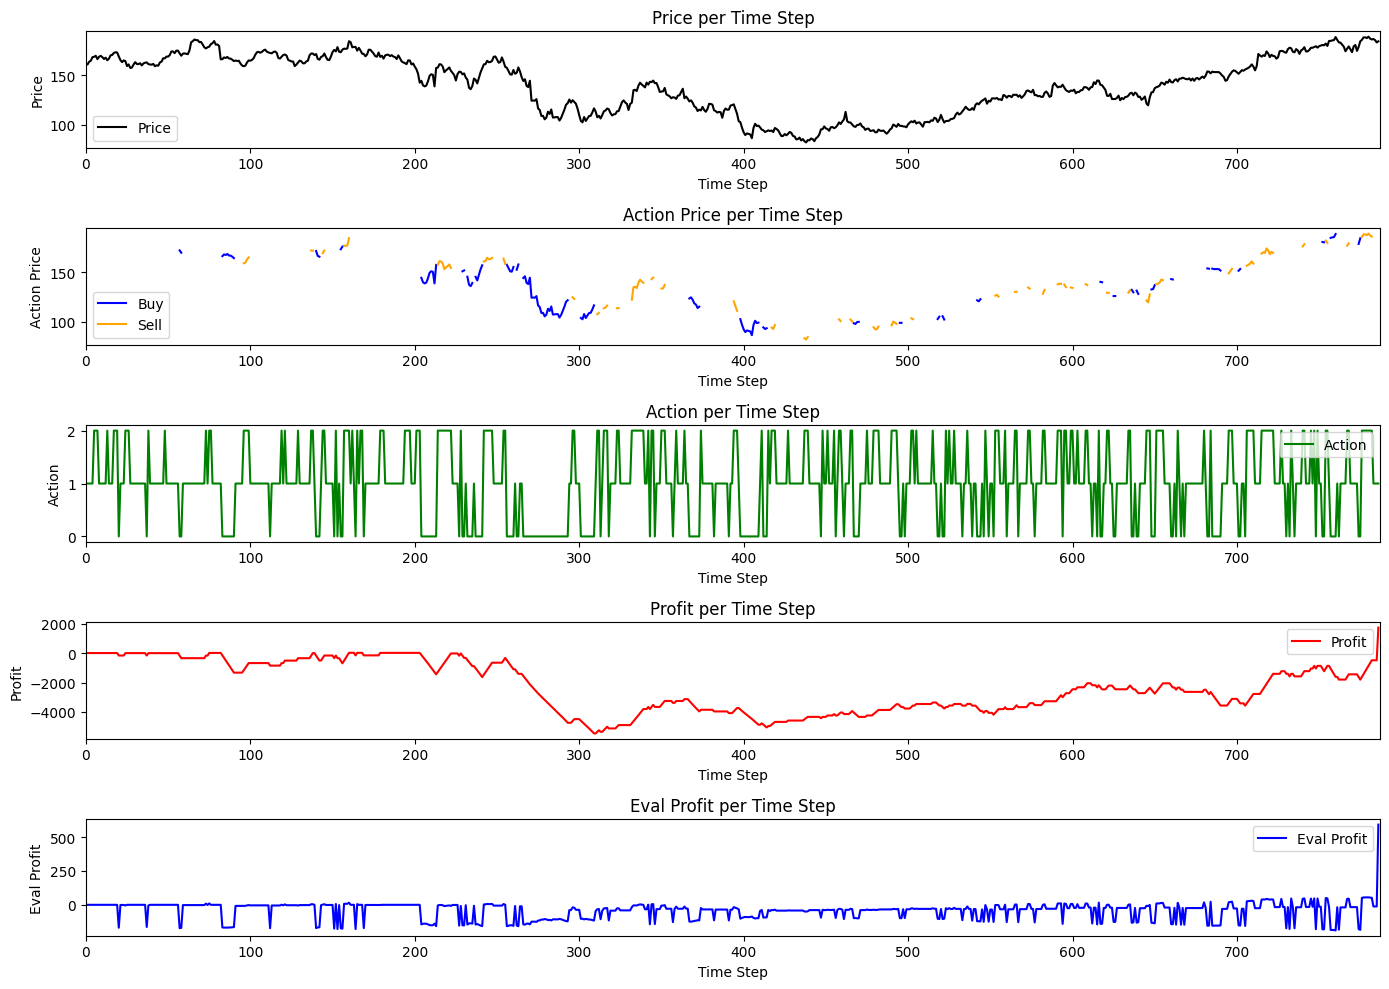

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 80.39it/s]


Ticker: ASML
CheckPoint: 270
Final Profit: 21621.359649658203
Win Rate: 0.3505747126436782
Eval Total Profit: -204325.21689115095
Total Profit: 21621.359649658203


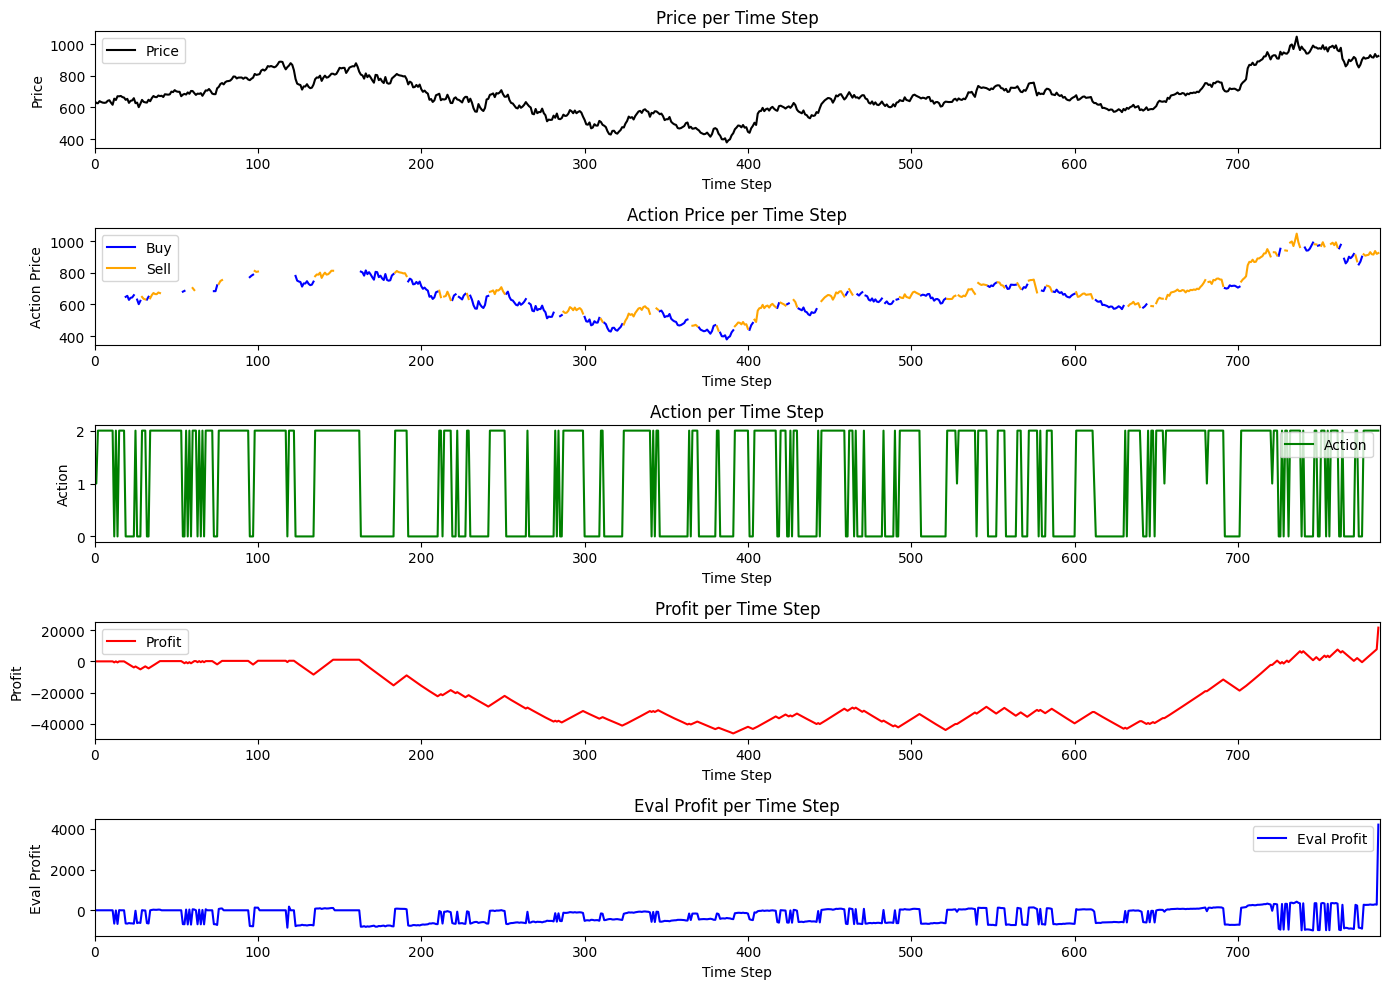

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 80.56it/s]


Ticker: AVGO
CheckPoint: 270
Final Profit: 15281.030151367188
Win Rate: 0.44954128440366975
Eval Total Profit: -163134.06617560686
Total Profit: 15281.030151367188


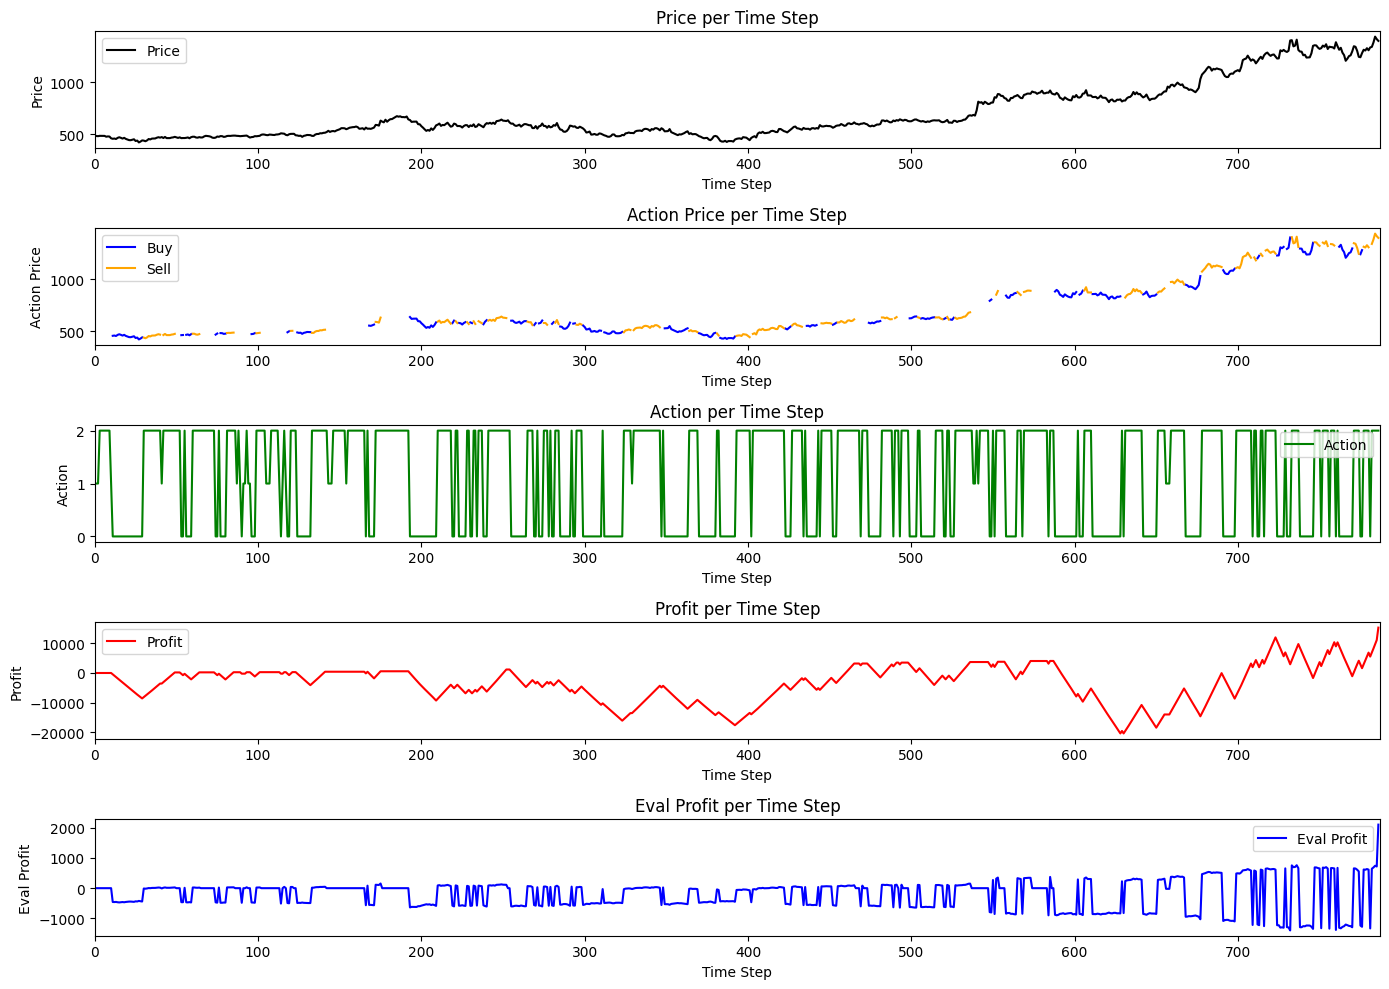

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 81.31it/s]


Ticker: COST
CheckPoint: 270
Final Profit: 5885.100524902344
Win Rate: 0.4714285714285714
Eval Total Profit: -127043.89247874414
Total Profit: 5885.100524902344


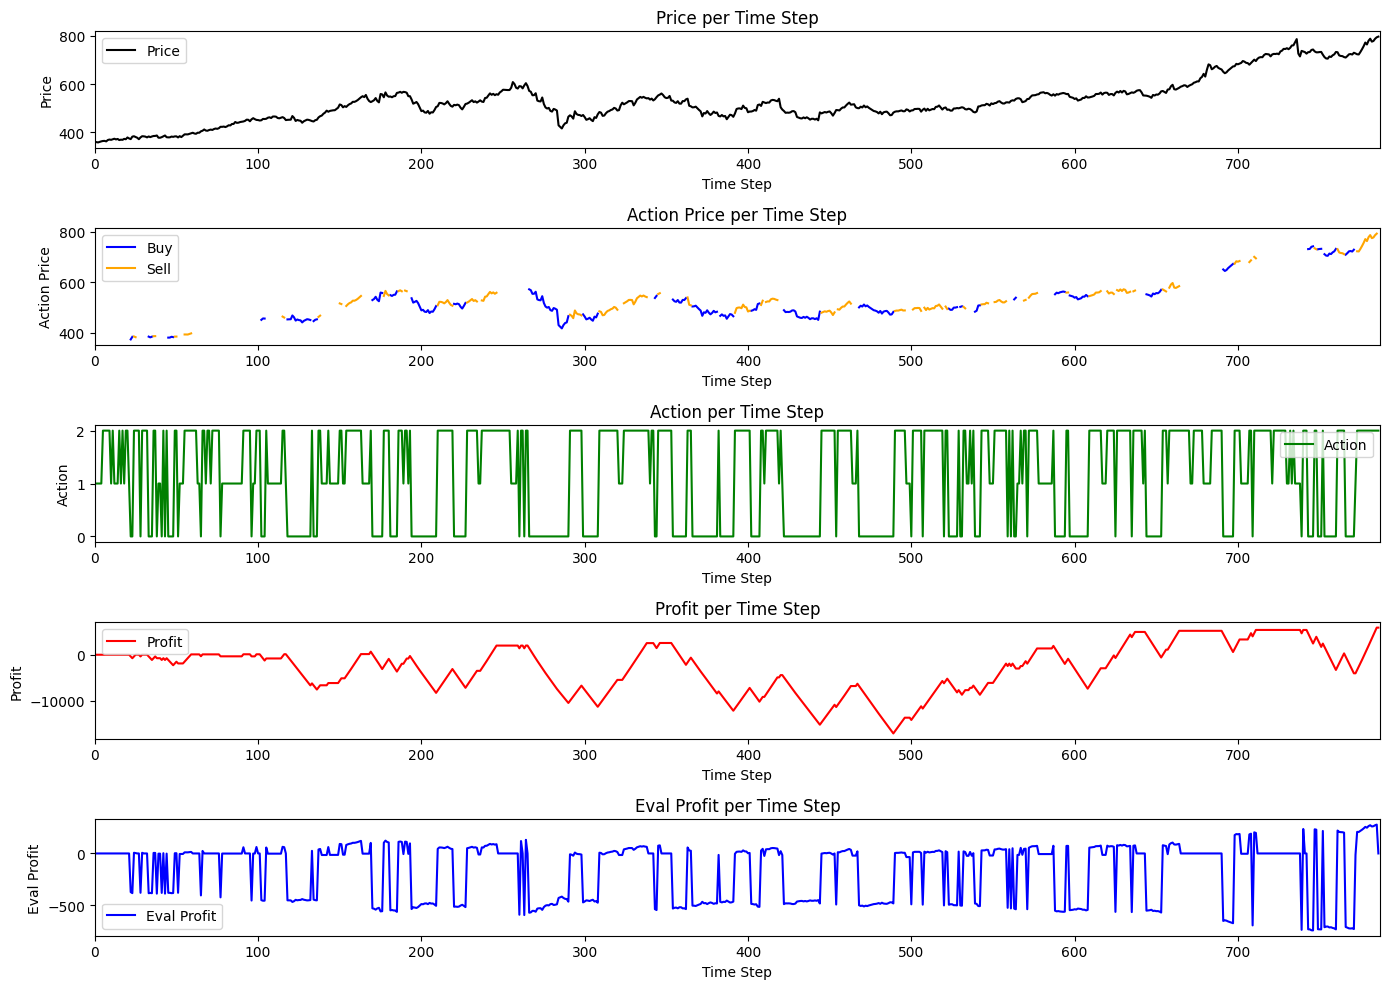

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:10<00:00, 77.52it/s]


Ticker: GOOG
CheckPoint: 270
Final Profit: 541.0740432739258
Win Rate: 0.31981981981981983
Eval Total Profit: -16290.098878075612
Total Profit: 541.0740432739258


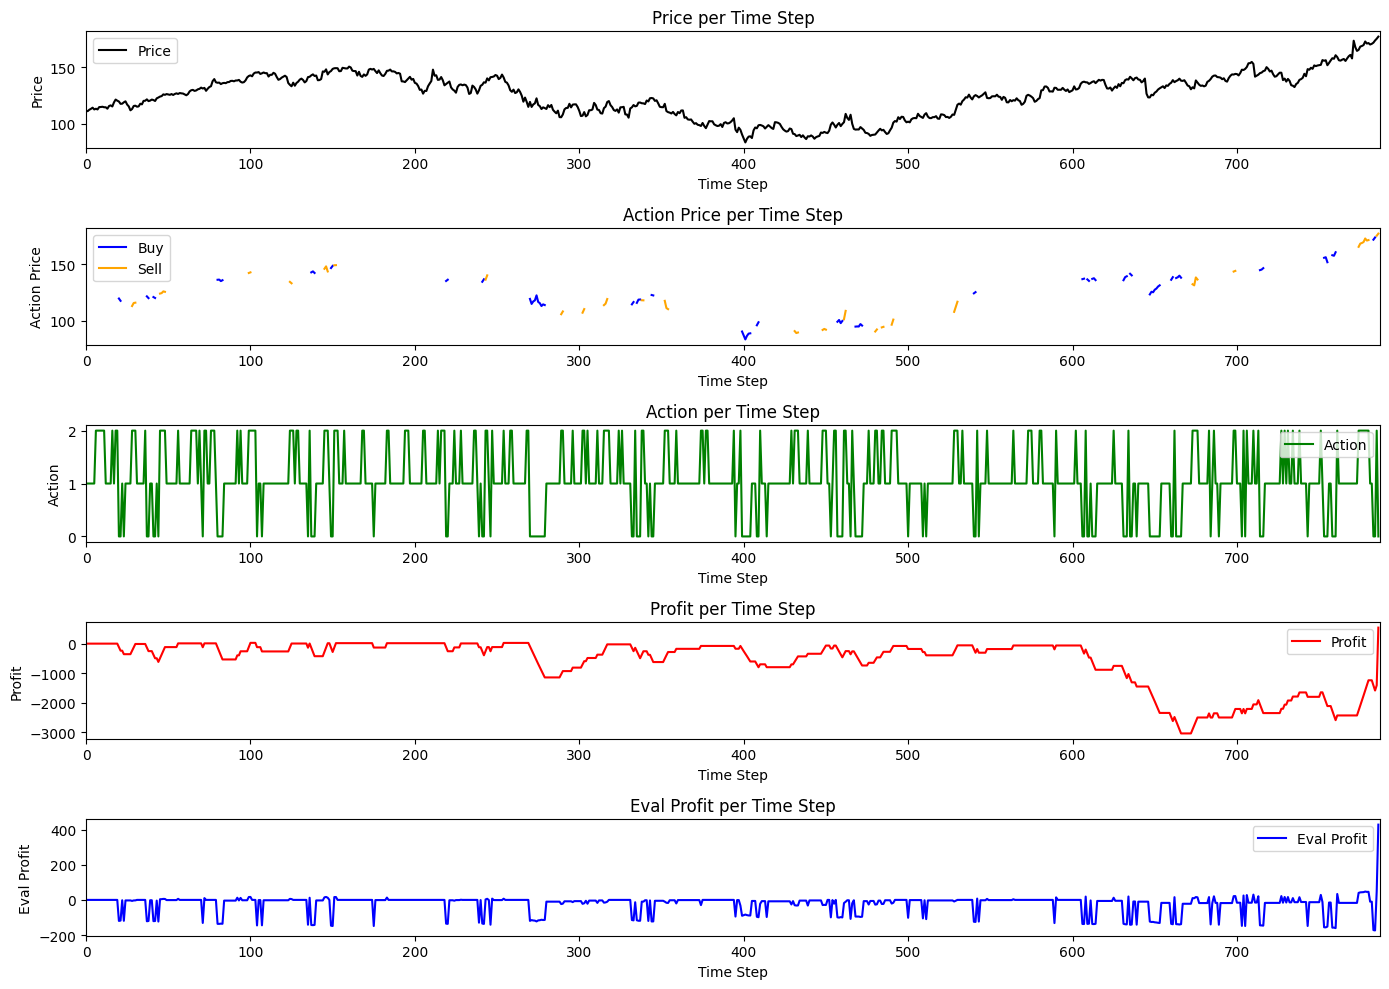

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:10<00:00, 77.38it/s]


Ticker: META
CheckPoint: 270
Final Profit: 12154.210060119629
Win Rate: 0.3122977346278317
Eval Total Profit: -80967.96471264596
Total Profit: 12154.210060119629


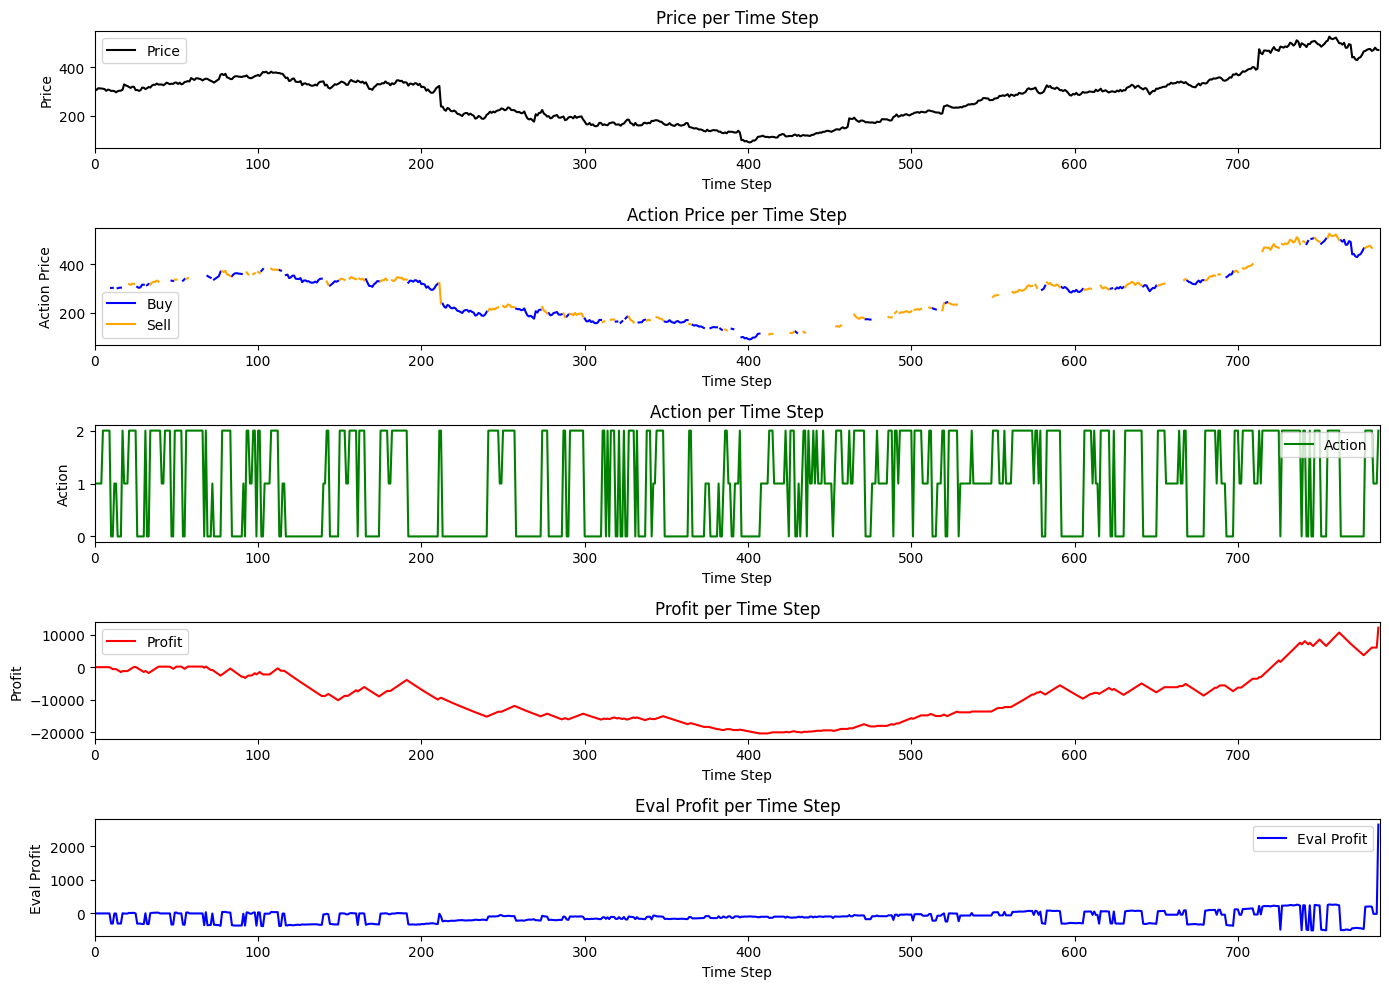

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 786/786 [00:10<00:00, 75.95it/s]


Ticker: MSFT
CheckPoint: 270
Final Profit: 6692.3101806640625
Win Rate: 0.36824877250409166
Eval Total Profit: -82882.60372087124
Total Profit: 6692.3101806640625


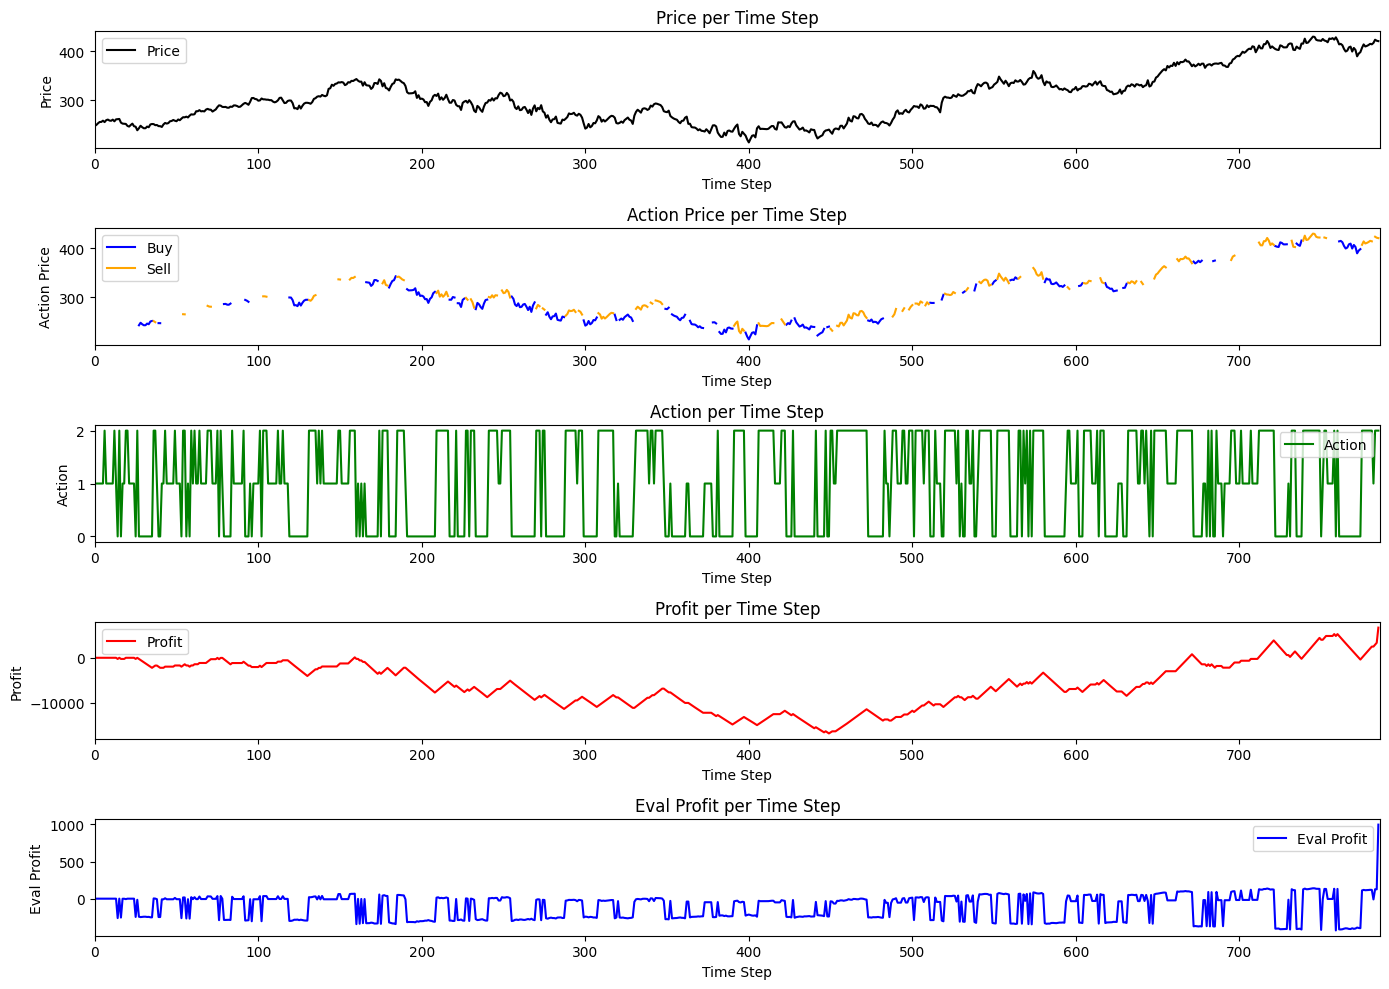

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 79.02it/s]


Ticker: NVDA
CheckPoint: 270
Final Profit: 147.16997909545898
Win Rate: 0.5538461538461539
Eval Total Profit: -2003.823667662606
Total Profit: 147.16997909545898


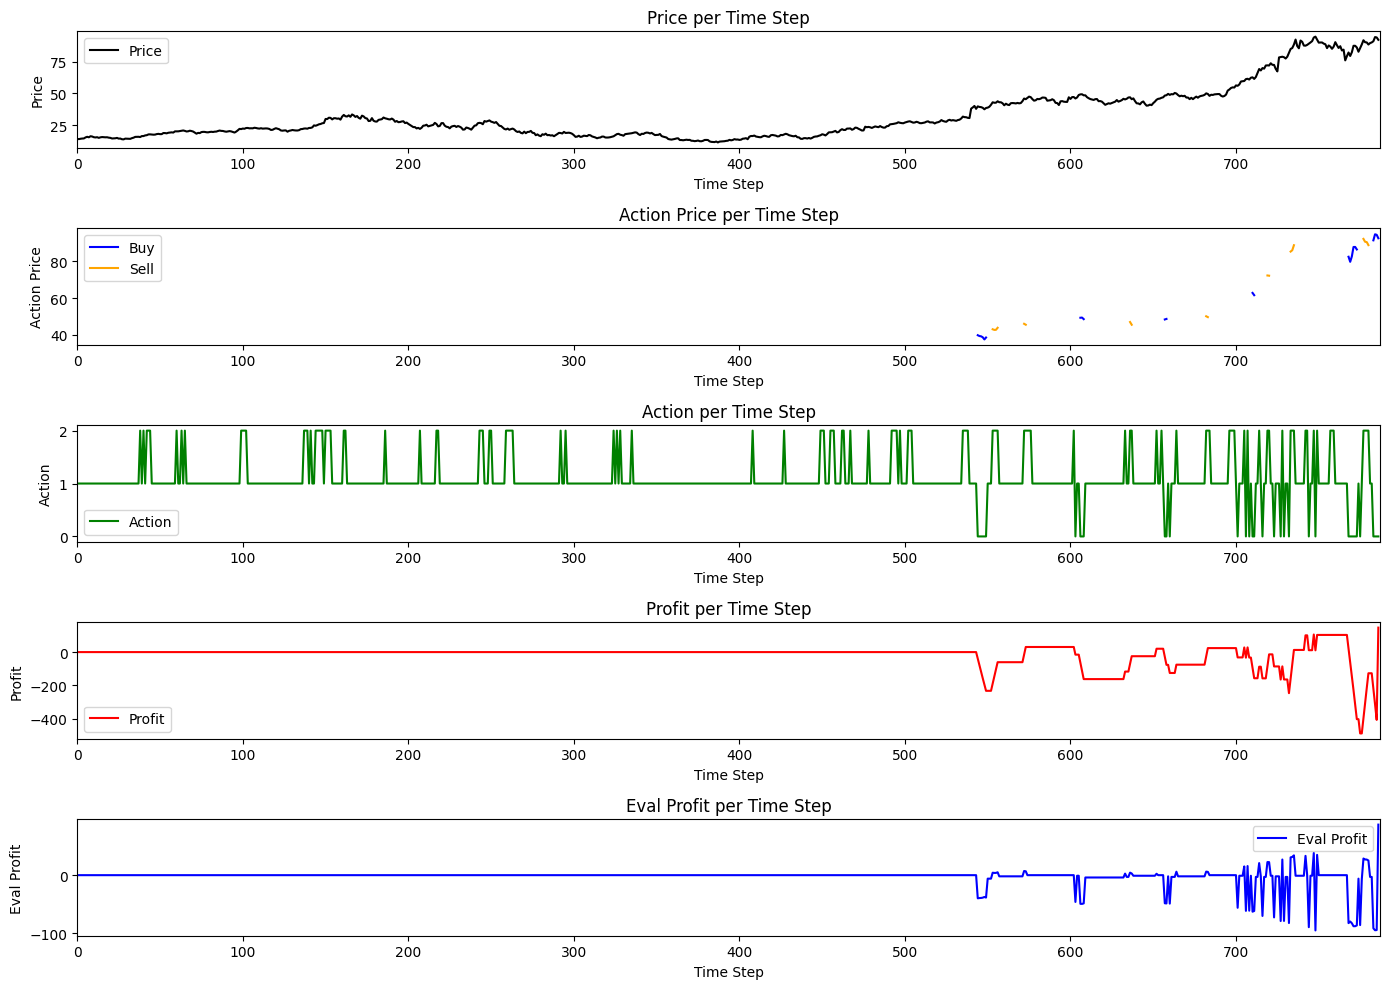

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 787/787 [00:09<00:00, 79.32it/s]


Ticker: TSLA
CheckPoint: 270
Final Profit: 299.4139709472656
Win Rate: 0.2351233671988389
Eval Total Profit: -96756.43130772708
Total Profit: 299.4139709472656


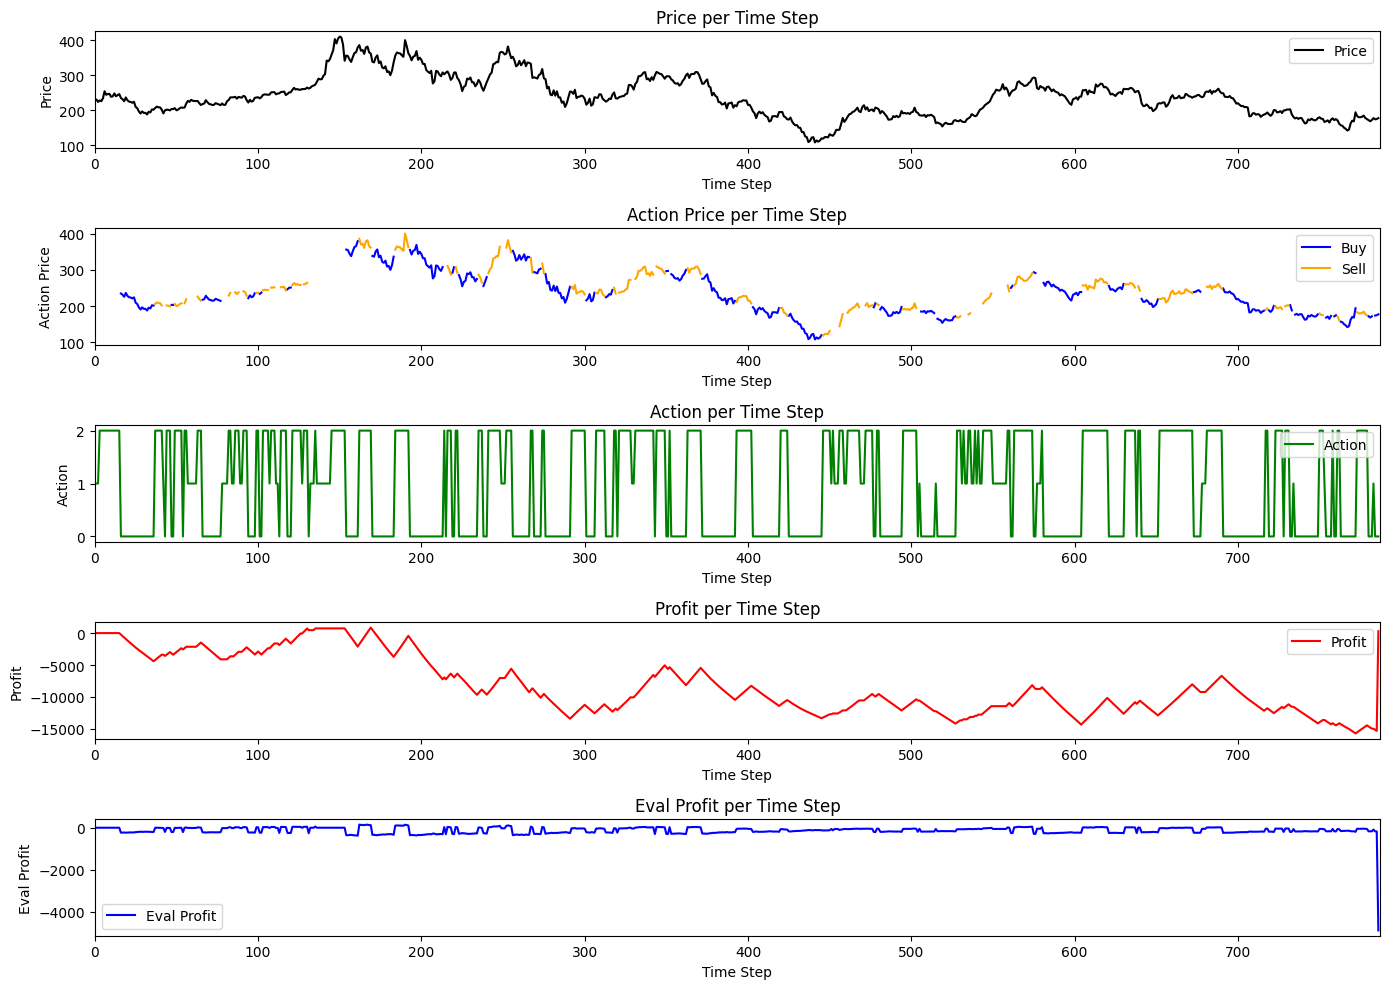

In [ ]:
for ticker in tickerList:
    visualise_checkpoint(ticker, 270)